In [17]:
import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.signal import welch


Cargamos los datos:

In [12]:
eeg1 = pd.read_csv("participantes/eeg_pp_7.csv")

features1 = pd.read_csv("participantes/eeg_features_7.csv")

In [4]:
eeg1.head()

,latency,fp1,fp2,f7,f3,fz,f4,f8,t7,c3,cz,c4,t8,p7,p3,pz,p4,p8,o1,o2
0,0.00281,26.386440,28.756460,32.243850,31.013860,24.529790,29.413450,40.834690,35.546010,33.001660,38.512820,-85.66660,29.716440,40.617970,32.473810,37.156540,36.769610,37.329090,66.031830,46.488990
1,0.00671,17.048110,18.925040,22.249790,15.872120,12.729780,17.557230,21.929130,26.956790,21.504540,23.657910,-42.04453,23.867600,34.621320,25.517370,27.325240,29.517200,24.655620,43.655370,31.650510
2,0.01062,-4.854121,-1.269097,-1.808615,-8.173519,-6.788488,-2.604407,-10.267810,3.130321,-1.302412,-0.204739,29.16659,3.233574,7.198804,3.631953,2.478549,5.599274,0.056756,-7.153692,-1.483879
3,0.01453,-9.556508,-5.014363,-7.768367,-10.576950,-8.894509,-5.663428,-15.763450,-3.163114,-5.667336,-3.817516,40.78624,-2.514843,-4.859041,-1.373253,-4.650784,-4.372041,-5.621758,-20.733740,-10.653490
4,0.01843,5.569838,7.900063,8.374804,6.393506,4.134678,7.272549,6.940441,12.425060,8.634451,10.947810,-8.02345,10.668380,9.109248,12.945970,9.212869,6.406528,9.612051,10.142710,8.278473


In [18]:
len(eeg1), len(features1)

(96768, 2330)

In [19]:
features1.isnull().sum()

epoch                   0
window                  0
n_samples               0
Start_w                 0
End_w                   0
                       ..
ch19-LowGamma-Kurt      0
ch19-LowGamma-RelPow    0
ch19-LowGamma-HjAct     0
ch19-LowGamma-HjMob     0
ch19-LowGamma-HjComp    0
Length: 1261, dtype: int64

In [20]:
features1['Trust'].value_counts(dropna=False)

Trust
3.0    1100
4.0     600
NaN     330
5.0     300
Name: count, dtype: int64

In [21]:
features1 = features1.dropna(subset=["Trust", "Binary_Trust"]).reset_index(drop=True)


Para llevar a cabo el análisis de la señal, hay que incorporar la columna "epoch" del dataset "features" al dataset con las señales EEG en crudo, para, más tarde, llevar a cabo la partición de los datos adecuada, se unirá esta columna según los valores de "Start_w" y "End_w" y considerando el valor de latencia de las señales. De esta manera, se obtendrá un dataset con las señales EEG en crudo, la epoch a la que pertenece, la latencia y el valor de Trust y Binary_Trust.

In [22]:
def assign_epochs(eeg1, features1):
    eeg1 = eeg1.copy()
    eeg1["epoch"] = np.nan
    eeg1["Trust"] = np.nan
    eeg1["Binary_Trust"] = np.nan
    
    for _, row in features1.iterrows():
        mask = (eeg1["latency"] >= row["Start_w"]) & (eeg1["latency"] <= row["End_w"])
        eeg1.loc[mask, "epoch"] = row["epoch"]
        eeg1.loc[mask, "Trust"] = row["Trust"]
        eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]
    
    return eeg1

# Asignar etiquetas
eeg1 = assign_epochs(eeg1, features1)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


C:\Users\crist\AppData\Local\Temp\ipykernel_44072\2393793452.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'low_trust' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  eeg1.loc[mask, "Binary_Trust"] = row["Binary_Trust"]


Sin epoch: 35247 de un total de 96768

Distribución Binary_Trust:
Binary_Trust
NaN           35247
low_trust     34012
high_trust    27509
Name: count, dtype: int64

Distribución Trust:
Trust
NaN    35247
3.0    34012
4.0    18231
5.0     9278
Name: count, dtype: int64


Podemos observar que nos queda un alto % de valores nulos, esto se debe a que el primer start_w comienza más tarde que el primer valor de latencia, y lo mismo para el último valor de end_w, termina antes que el último valor de latencia. Estos nulos pueden corresponder con valores erróneos en la colocación inicial del casco o al momento de acabar el experimento, por lo que optamos por eliminarlos.

In [23]:
# Eliminar filas donde alguna de las columnas clave es NaN
eeg1 = eeg1.dropna(subset=['epoch', 'Trust', 'Binary_Trust']).reset_index(drop=True)

# Ver cuántos valores se quedaron sin epoch
print("Sin epoch:", eeg1["epoch"].isna().sum(), "de un total de", len(eeg1))

# Ver distribución de etiquetas
print("\nDistribución Binary_Trust:")
print(eeg1["Binary_Trust"].value_counts(dropna=False))

print("\nDistribución Trust:")
print(eeg1["Trust"].value_counts(dropna=False))


Sin epoch: 0 de un total de 61521

Distribución Binary_Trust:
Binary_Trust
low_trust     34012
high_trust    27509
Name: count, dtype: int64

Distribución Trust:
Trust
3.0    34012
4.0    18231
5.0     9278
Name: count, dtype: int64


C:\Users\crist\AppData\Local\Temp\ipykernel_44072\1673612113.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm', order=['high_trust', 'low_trust'])
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_

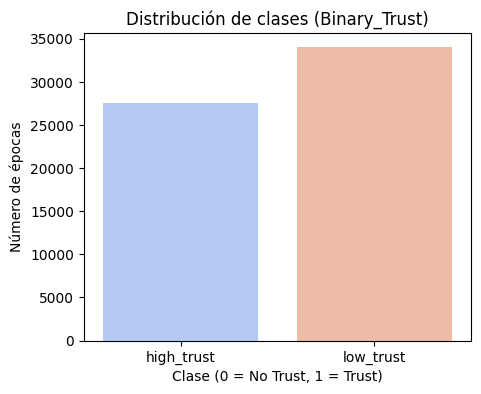

Distribución porcentual:
 Binary_Trust
low_trust     0.552852
high_trust    0.447148
Name: proportion, dtype: float64


In [24]:
plt.figure(figsize=(5,4))
sns.countplot(x=eeg1['Binary_Trust'], palette='coolwarm', order=['high_trust', 'low_trust'])
plt.title("Distribución de clases (Binary_Trust)")
plt.xlabel("Clase (0 = No Trust, 1 = Trust)")
plt.ylabel("Número de épocas")
plt.show()

print("Distribución porcentual:\n", eeg1['Binary_Trust'].value_counts(normalize=True))

## Red Neuronal EEGNet

In [25]:
from braindecode import EEGClassifier
from braindecode.models import EEGNet
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
from skorch.helper import predefined_split

In [12]:
fs = 1 / (eeg1['latency'].iloc[1] - eeg1['latency'].iloc[0])
print("Frecuencia de muestreo (Hz):", fs)

Frecuencia de muestreo (Hz): 255.75024390241725


### Trial Wise

Dividimos los datos de manera que no queden muestras mezcladas en los distintos conjuntos de entrenamiento, validación y test

In [26]:
# Identificar todos los trials (epochs)
epochs = eeg1['epoch'].dropna().unique()

# Asociar cada trial a su etiqueta de confianza binaria
binary_trust_in_epoch = eeg1.groupby('epoch')['Binary_Trust'].first()

# Dividir trials en train, test y validación 
epochs_train, epochs_test = train_test_split(
    epochs,
    test_size=0.2,
    stratify=binary_trust_in_epoch.loc[epochs].values,
    random_state=42
)

# Dentro de train, split train/valid
epochs_train, epochs_valid = train_test_split(
    epochs_train,
    test_size=0.2,  
    stratify=binary_trust_in_epoch[epochs_train],
    random_state=42
)

df_train = eeg1[eeg1['epoch'].isin(epochs_train)].reset_index(drop=True)
df_valid = eeg1[eeg1['epoch'].isin(epochs_valid)].reset_index(drop=True)
df_test  = eeg1[eeg1['epoch'].isin(epochs_test)].reset_index(drop=True)

def make_trial_windows(df, window_size, stride):
    trials = df['epoch'].unique()
    X_list, y_list = [], []

    for trial in trials:
        trial_df = df[df['epoch']==trial].drop(columns=['latency','Trust','Binary_Trust','epoch'], errors='ignore')
        trial_signals = trial_df.values  
        label = df[df['epoch']==trial]['Binary_Trust'].iloc[0]
        label_bin = 0 if label=='low_trust' else 1

        # Extraer ventanas con stride
        for start in range(0, trial_signals.shape[0] - window_size + 1, stride):
            window = trial_signals[start:start+window_size, :]
            X_list.append(window.T)  
            y_list.append(label_bin)

    X_tensor = torch.tensor(X_list, dtype=torch.float32)
    y_tensor = torch.tensor(y_list, dtype=torch.long)

    return X_tensor, y_tensor

X_train_t, y_train_t = make_trial_windows(df_train, window_size=256, stride=32)
X_valid_t, y_valid_t = make_trial_windows(df_valid, window_size=256, stride=32)
X_test_t,  y_test_t  = make_trial_windows(df_test,  window_size=256, stride=32)

print(X_train_t.shape, y_train_t.shape)




torch.Size([514, 19, 256]) torch.Size([514])


C:\Users\crist\AppData\Local\Temp\ipykernel_44072\2140446122.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_tensor = torch.tensor(X_list, dtype=torch.float32)


### Selección de características

#### Métodos de filtro

In [ ]:
# Selección de canales (ANOVA) 
from sklearn.feature_selection import f_classif
import numpy as np

# Convertimos a numpy y aplanamos por tiempo para tener una feature por canal
X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Calculamos F y p-values
F_values, pvals = f_classif(X_train_mean, y_np)

# Escogemos los canales con p<0.05 (significativos)
k = 13 
selected_channels = np.argsort(F_values)[-k:] 
print("Canales seleccionados:", selected_channels)


# Filtramos los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]

print("Nueva forma de X_train:", X_train_t.shape)


Canales seleccionados: [ 9 10 12 11 17  5  1  8 14  4 16 18 15]
Nueva forma de X_train: torch.Size([514, 13, 256])


In [ ]:
from sklearn.feature_selection import mutual_info_classif

X_train_mean = X_train_t.mean(dim=2).numpy()
y_np = y_train_t.numpy()

# Mutual information
mi = mutual_info_classif(X_train_mean, y_np, random_state=42)
selected_channels = np.argsort(mi)[-10:]  # Top 10 canales

print("Canales seleccionados (MI):", selected_channels)

# Filtra los tensores
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Nueva forma de X_train:", X_train_t.shape)

Canales seleccionados (MI): [12  4  9  8 15 11  6 14 18  2]
Nueva forma de X_train: torch.Size([514, 10, 256])


#### Método híbrido (filter+wrapper)

In [174]:
from sklearn.feature_selection import mutual_info_classif, SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

X_mean = X_train_t.numpy().mean(axis=2)
mi = mutual_info_classif(X_mean, y_train_t.numpy(), random_state=42)
top_k = min(14, X_mean.shape[1])
top_channels = np.argsort(mi)[-top_k:]
X_filtered = X_mean[:, top_channels]

wrapper = SequentialFeatureSelector(
        LogisticRegression(max_iter=1000),
        n_features_to_select=min(10, top_k),
        direction='forward',
        n_jobs=-1
    )
wrapper.fit(X_filtered, y_train_t.numpy())
selected_channels = top_channels[wrapper.get_support()]
X_train_t = X_train_t[:, selected_channels, :]
X_valid_t = X_valid_t[:, selected_channels, :]
X_test_t  = X_test_t[:, selected_channels, :]
print("Canales finales (híbrido):", selected_channels)


Canales finales (híbrido): [ 3 12  4  9  8 15 11 14 18  2]


### Normalización de los datos

In [27]:
mean = X_train_t.mean(dim=(0,2), keepdim=True) 
std  = X_train_t.std(dim=(0,2), keepdim=True)
X_train_t = (X_train_t - mean) / (std + 1e-8)
X_valid_t = (X_valid_t - mean) / (std + 1e-8)
X_test_t  = (X_test_t - mean) / (std + 1e-8)


In [439]:
overlap = set(epochs_train).intersection(set(epochs_test))
print("Épocas repetidas en train y test:", overlap)

Épocas repetidas en train y test: set()


In [ ]:
print("Train windows:", X_train_t.shape[0])
print("Valid windows:", X_valid_t.shape[0])
print("Test windows:",  X_test_t.shape[0])


Train windows: 537
Valid windows: 161
Test windows: 214
epoch
2.0        50
3.0       453
4.0       613
5.0      1517
6.0       202
         ... 
221.0      50
222.0     311
223.0     639
224.0     255
225.0     127
Length: 200, dtype: int64
Media de muestras por trial: 339.49
Mínimo de muestras por trial: 45
Máximo de muestras por trial: 1517


### Modelo y entrenamiento

#### Creación del modelo

In [ ]:
chans = 10      
nb_classes = 2   

model = EEGNet(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
    F1=8,F2=16,
)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

#### Entrenamiento del modelo

In [63]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=False,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-3,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[ 
               early_stopping],
    max_epochs=30,
    device='cpu',
)


In [64]:
clf.fit(X_train_t, y_train_t)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7135       0.4595        0.6932  1.0409
      2        0.7114       0.4324        0.6951  0.6438
      3        0.6847       0.4730        0.6968  0.6071
      4        0.6926       0.4865        0.6984  0.6107
      5        0.6749       0.4865        0.7014  0.6339
      6        0.6629       0.5135        0.7055  0.7718
      7        0.6586       0.5000        0.7126  0.7870
      8        0.6511       0.4865        0.7229  0.7040
      9        0.6249       0.5135        0.7306  0.7396
     10        0.6198       0.5135        0.7440  0.9675
     11        0.6142       0.5135        0.7610  0.8681
     12        0.5971       0.5135        0.7670  0.7621
     13        0.5967       0.5135        0.7820  0.7394
     14        0.5742       0.5135        0.8113  0.7719
     15        0.5498       0.5135        0.8447  0.7154
     16        0.5414       0.5

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 10, 256]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 10, 256]              [1, 10, 256, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 10, 256, 1]           [1, 1, 10, 256]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 10, 256]           [1, 8, 10, 257]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 10, 257]           [1, 8, 10, 257]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 10, 257]           [1, 16, 1, 257]           --                        [10, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 10, 1]            160                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 257]           [1, 16, 1, 257]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 257]           [1, 16, 1, 257]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 257]           [1, 16, 1, 64]            --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 64]            [1, 16, 1, 64]            --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 64]            [1, 16, 1, 65]            256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 65]            [1, 16, 1, 65]            256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 65]            [1, 16, 1, 65]            32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 65]            [1, 16, 1, 65]            --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 65]            [1, 16, 1, 8]             --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 8]             [1, 16, 1, 8]             --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 8]             [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 8]             [1, 2, 1, 1]              258                       [1, 8]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  ==========================================================================================================

#### Test

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[111   3]
 [ 77   0]]
              precision    recall  f1-score   support

           0       0.59      0.97      0.74       114
           1       0.00      0.00      0.00        77

    accuracy                           0.58       191
   macro avg       0.30      0.49      0.37       191
weighted avg       0.35      0.58      0.44       191



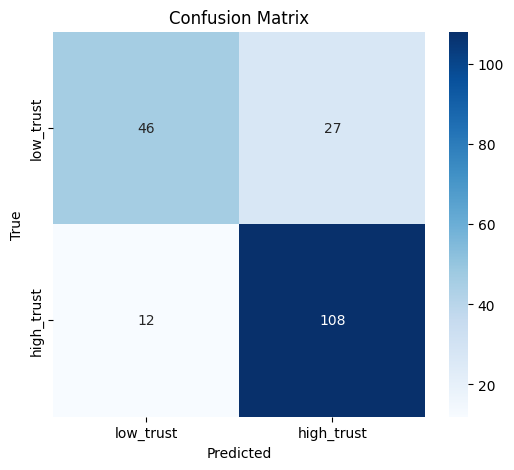

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_valid_t)[:, 1]  
y_true = y_valid_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.149


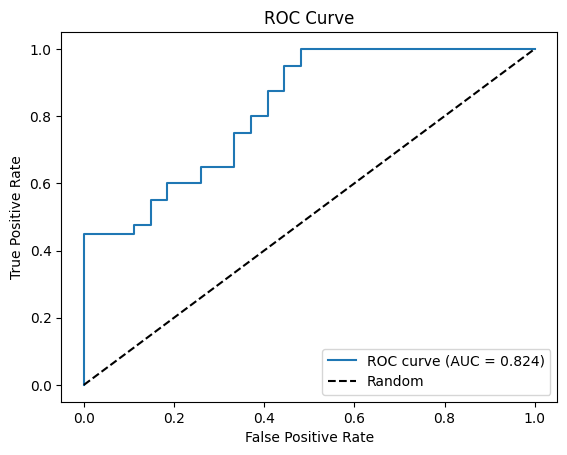

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### RED EEGNeX

In [14]:
from braindecode.models import EEGNeX

In [28]:
chans = 19    
nb_classes = 2   

model = EEGNeX(
    n_chans= chans,
    n_outputs= nb_classes,
    input_window_seconds= 1,
    n_times = 256,
    drop_prob=0.5,
)

In [29]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

criterion = torch.nn.CrossEntropyLoss()

In [30]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-2,
    optimizer__lr=1e-3,
    batch_size=64,
    callbacks=[
               early_stopping],
    max_epochs=30,
    device='cpu',
)


In [31]:
clf.fit(X_train_t, y_train_t)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1028.)
  return F.conv2d(


  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.7113       0.4865        0.7049  15.4113
      2        0.6784       0.4865        0.7179  13.9815
      3        0.6509       0.4459        0.7992  13.3288
      4        0.6149       0.3919        0.8612  13.8957
      5        0.5963       0.3378        1.0004  20.8079
      6        0.5563       0.2838        1.0249  16.1118
      7        0.5276       0.2973        1.1281  14.3052
      8        0.5315       0.2568        1.4354  13.2514
      9        0.4742       0.2568        1.5452  13.2672
     10        0.4660       0.2162        1.4653  13.6830
     11        0.4313       0.3649        1.3705  11.8661
     12        0.3967       0.3243        1.4609  14.4712
     13        0.3621       0.2973        1.7311  13.7340
     14        0.3462       0.2703        1.7442  15.3659
     15        0.3213       0.2703        1.8591  15.5348
Stopping since

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNeX (EEGNeX)                                              [1, 19, 256]              [1, 2]                    --                        --
  ├─Sequential (block_1): 1-1                                  [1, 19, 256]              [1, 8, 19, 256]           --                        --
  │    └─Rearrange (0): 2-1                                    [1, 19, 256]              [1, 1, 19, 256]           --                        --
  │    └─Conv2d (1): 2-2                                       [1, 1, 19, 256]           [1, 8, 19, 256]           512                       [1, 64]
  │    └─BatchNorm2d (2): 2-3                                  [1, 8, 19, 256]           [1, 8, 19, 256]           16                        --
  ├─Sequential (block_2): 1-2                                  [1, 8, 19, 256]           [1, 32, 19, 256]          --                        --
  │    └─Conv2d (0): 2-4                                       [1, 8, 19, 256]           [1, 32, 19, 256]          16,384                    [1, 64]
  │    └─BatchNorm2d (1): 2-5                                  [1, 32, 19, 256]          [1, 32, 19, 256]          64                        --
  ├─Sequential (block_3): 1-3                                  [1, 32, 19, 256]          [1, 64, 1, 64]            --                        --
  │    └─ParametrizedConv2dWithConstraint (0): 2-6             [1, 32, 19, 256]          [1, 64, 1, 256]           --                        [19, 1]
  │    │    └─ModuleDict (parametrizations): 3-1               --                        --                        1,216                     --
  │    └─BatchNorm2d (1): 2-7                                  [1, 64, 1, 256]           [1, 64, 1, 256]           128                       --
  │    └─ELU (2): 2-8                                          [1, 64, 1, 256]           [1, 64, 1, 256]           --                        --
  │    └─AvgPool2d (3): 2-9                                    [1, 64, 1, 256]           [1, 64, 1, 64]            --                        [1, 4]
  │    └─Dropout (4): 2-10                                     [1, 64, 1, 64]            [1, 64, 1, 64]            --                        --
  ├─Sequential (block_4): 1-4                                  [1, 64, 1, 64]            [1, 32, 1, 64]            --                        --
  │    └─Conv2d (0): 2-11                                      [1, 64, 1, 64]            [1, 32, 1, 64]            32,768                    [1, 16]
  │    └─BatchNorm2d (1): 2-12                                 [1, 32, 1, 64]            [1, 32, 1, 64]            64                        --
  ├─Sequential (block_5): 1-5                                  [1, 32, 1, 64]            [1, 64]                   --                        --
  │    └─Conv2d (0): 2-13                                      [1, 32, 1, 64]            [1, 8, 1, 64]             4,096                     [1, 16]
  │    └─BatchNorm2d (1): 2-14                                 [1, 8, 1, 64]             [1, 8, 1, 64]             16                        --
  │    └─ELU (2): 2-15                                         [1, 8, 1, 64]             [1, 8, 1, 64]             --                        --
  │    └─AvgPool2d (3): 2-16                                   [1, 8, 1, 64]             [1, 8, 1, 8]              --                        [1, 8]
  │    └─Dropout (4): 2-17                                     [1, 8, 1, 8]              [1, 8, 1, 8]     

In [33]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[71 43]
 [21 56]]
              precision    recall  f1-score   support

           0       0.77      0.62      0.69       114
           1       0.57      0.73      0.64        77

    accuracy                           0.66       191
   macro avg       0.67      0.68      0.66       191
weighted avg       0.69      0.66      0.67       191



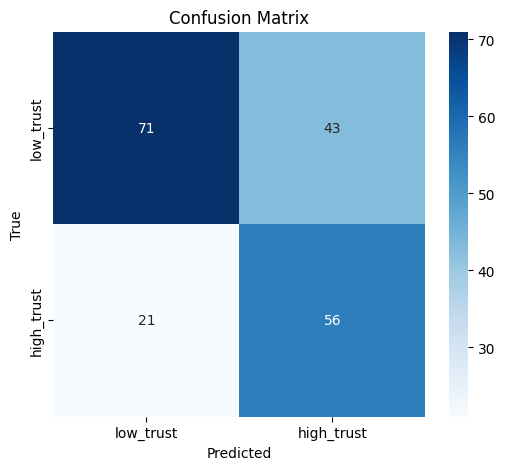

In [35]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [34]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.692


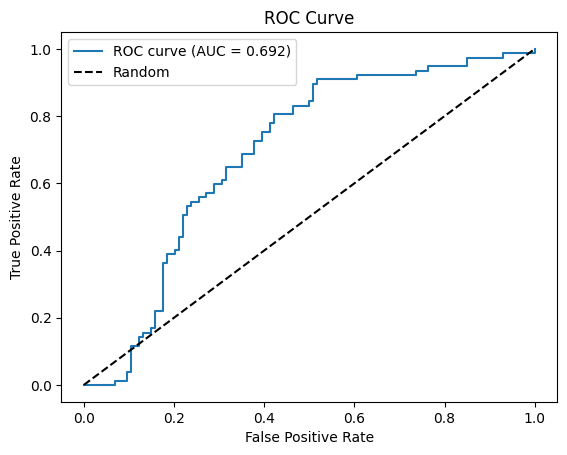

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### Almacén del modelo

In [37]:
import os
import pickle

subject_id = 'P7'
folder_path = 'artifacts/p7'
os.makedirs(folder_path, exist_ok=True)

# Guardar modelo y configuración
try:
    # Guardamos los pesos del modelo y optimizador 
    clf.save_params(
        f_params=os.path.join(folder_path, f'model_weights_{subject_id}.pt'),
        f_optimizer=os.path.join(folder_path, f'opt_{subject_id}.pt'),
        f_history=os.path.join(folder_path, f'history_{subject_id}.json')
    )
    
    # Guardamos los hiperparámetros 
    config_params = clf.get_params()
    config_params.pop('module', None) 
    
    with open(os.path.join(folder_path, f'config_{subject_id}.pkl'), 'wb') as f:
        pickle.dump(config_params, f)

except RuntimeError:
    import torch
    torch.save(clf.module_.state_dict(), os.path.join(folder_path, f'state_dict_{subject_id}.pt'))

# GUARDAR PREDICCIONES 
y_pred = clf.predict(X_test_t)
y_probs = clf.predict_proba(X_test_t)[:, 1]

df_preds = pd.DataFrame({
    'Real': y_test_t.cpu().numpy() if hasattr(y_test_t, 'cpu') else y_test_t,
    'Prediccion': y_pred,
    'Probabilidad': y_probs
})

df_preds.to_excel(os.path.join(folder_path, f'predicciones_{subject_id}.xlsx'), index=False)



## AttentionBaseNet

In [120]:
from braindecode.models import AttentionBaseNet


In [187]:
model = AttentionBaseNet(
    n_chans=19,
    n_outputs=2,
    n_times=256,
    drop_prob_inp=0.6,
    drop_prob_attn= 0.3,

)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_counts = torch.tensor([sum(y_train_t==0), sum(y_train_t==1)], dtype=torch.float32)
class_weights = 1. / class_counts
class_weights = class_weights / class_weights.sum()

class_weights_tensor = torch.tensor([0.45, 0.55], dtype=torch.float32)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

In [189]:
from skorch.callbacks import EarlyStopping, EpochScoring

f1_macro = EpochScoring(scoring='f1_macro', lower_is_better=False, on_train=False)

early_stopping = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=0.001,
    lower_is_better=True,
)

valid_loader =TensorDataset(X_valid_t, y_valid_t)

clf = EEGClassifier(
    model,
    criterion= criterion,
    train_split=predefined_split(valid_loader),
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=5e-3,
    optimizer__lr=1e-4,
    batch_size=32,
    callbacks=[ 
               early_stopping],
    max_epochs=40,
    device='cpu',
)


In [190]:
clf.fit(
    X_train_t, 
    y_train_t, 
)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7106       0.5135        0.7326  0.8613
      2        0.6868       0.3919        0.7861  0.7963
      3        0.6762       0.3649        0.8244  0.8006
      4        0.6834       0.3784        0.8439  0.8039
      5        0.6865       0.3919        0.8630  0.7860
      6        0.6976       0.3919        0.8701  0.8341
      7        0.6775       0.3649        0.8723  0.9506
      8        0.6682       0.3649        0.8770  0.8245
      9        0.6586       0.3784        0.8748  0.8327
     10        0.6606       0.3784        0.8800  0.8440
     11        0.6725       0.3649        0.8858  0.8219
     12        0.6634       0.3784        0.8936  0.8231
     13        0.6668       0.3784        0.9069  0.8506
     14        0.6648       0.3784        0.9114  0.9108
     15        0.6600       0.3649        0.9123  0.8763
Stopping since valid_loss has n

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  AttentionBaseNet (AttentionBaseNet)                          [1, 19, 256]              [1, 2]                    --                        --
  ├─_FeatureExtractor (input_block): 1-1                       [1, 19, 256]              [1, 40, 1, 13]            --                        --
  │    └─Ensure4d (ensure4d): 2-1                              [1, 19, 256]              [1, 19, 256, 1]           --                        --
  │    └─Rearrange (rearrange_input): 2-2                      [1, 19, 256, 1]           [1, 1, 19, 256]           --                        --
  │    └─Conv2d (temporal_conv): 2-3                           [1, 1, 19, 256]           [1, 40, 19, 256]          1,000                     [1, 25]
  │    └─BatchNorm2d (intermediate_bn): 2-4                    [1, 40, 19, 256]          [1, 40, 19, 256]          80                        --
  │    └─Conv2d (spatial_conv): 2-5                            [1, 40, 19, 256]          [1, 40, 1, 256]           760                       [19, 1]
  │    └─BatchNorm2d (bn): 2-6                                 [1, 40, 1, 256]           [1, 40, 1, 256]           80                        --
  │    └─ELU (nonlinearity): 2-7                               [1, 40, 1, 256]           [1, 40, 1, 256]           --                        --
  │    └─AvgPool2d (pool): 2-8                                 [1, 40, 1, 256]           [1, 40, 1, 13]            --                        [1, 75]
  │    └─Dropout (dropout): 2-9                                [1, 40, 1, 13]            [1, 40, 1, 13]            --                        --
  ├─Sequential (channel_expansion): 1-2                        [1, 40, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─Conv2d (0): 2-10                                      [1, 40, 1, 13]            [1, 16, 1, 13]            640                       [1, 1]
  │    └─BatchNorm2d (1): 2-11                                 [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    └─ELU (2): 2-12                                         [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  ├─_ChannelAttentionBlock (channel_attention_block): 1-3      [1, 16, 1, 13]            [1, 16, 1, 1]             --                        --
  │    └─Sequential (conv): 2-13                               [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    │    └─Conv2d (0): 3-1                                  [1, 16, 1, 13]            [1, 16, 1, 13]            240                       [1, 15]
  │    │    └─Conv2d (1): 3-2                                  [1, 16, 1, 13]            [1, 16, 1, 13]            256                       [1, 1]
  │    │    └─BatchNorm2d (2): 3-3                             [1, 16, 1, 13]            [1, 16, 1, 13]            32                        --
  │    │    └─ELU (3): 3-4                                     [1, 16, 1, 13]            [1, 16, 1, 13]            --                        --
  │    └─AvgPool2d (pool): 2-14                                [1, 16, 1, 13]            [1, 16, 1, 1]             --                        [1, 8]
  │    └─Dropout (dropout): 2-15                               [1, 16, 1, 1]             [1, 16, 1, 1]             --                        --
  ├─Sequential (final_layer): 1-4                              [1, 16, 1, 1]             [1, 2]            

In [ ]:
# Obtener predicciones
y_pred = clf.predict(X_test_t)

# Métricas más completas 
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test_t, y_pred))
print(classification_report(y_test_t, y_pred))

[[79 35]
 [38 39]]
              precision    recall  f1-score   support

           0       0.68      0.69      0.68       114
           1       0.53      0.51      0.52        77

    accuracy                           0.62       191
   macro avg       0.60      0.60      0.60       191
weighted avg       0.62      0.62      0.62       191



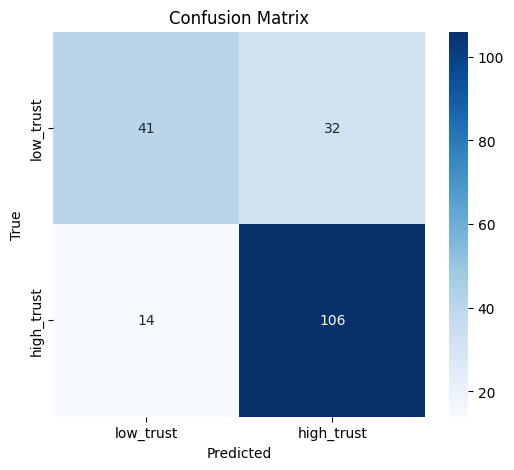

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_t, y_pred)

# Nombres de las clases
class_names = ['low_trust', 'high_trust']

# Crear el heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = clf.predict_proba(X_test_t)[:, 1]  
y_true = y_test_t.numpy()

roc_auc = roc_auc_score(y_true, y_proba)
print(f"ROC-AUC: {roc_auc:.3f}")


ROC-AUC: 0.638


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_proba)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
